In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    mean_squared_error, r2_score, classification_report, precision_score,
    recall_score, f1_score, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, accuracy_score
)

from lightgbm import LGBMRegressor, LGBMClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [137]:
# Load the dataset
df = pd.read_csv("10k_diabetes (1).csv")

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

# Display first few rows
print("\nFirst few rows of the dataset:")
df.head()

# Check missing values
print("\nMissing values in each column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Dataset Shape: (10000, 51)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      10000 non-null  object
 1   gender                    10000 non-null  object
 2   age                       10000 non-null  object
 3   weight                    10000 non-null  object
 4   admission_type_id         9279 non-null   object
 5   discharge_disposition_id  9531 non-null   object
 6   admission_source_id       9064 non-null   object
 7   time_in_hospital          10000 non-null  int64 
 8   payer_code                10000 non-null  object
 9   medical_specialty         10000 non-null  object
 10  num_lab_procedures        10000 non-null  int64 
 11  num_procedures            10000 non-null  int64 
 12  num_medications           10000 non-null  int64 
 13  number_outpatient         10000 non

In [138]:
# Replace '?' with 'Unknown' for weight
df['weight'] = df['weight'].replace('?', 'Unknown')

# Replace '?' with 'Unknown' for weight
df['medical_specialty'] = df['medical_specialty'].replace('?', 'Unknown')

df['payer_code'] = df['payer_code'].replace("?", 'Unknown')


# Fill missing admission types with mode
df['admission_type_id'] = df['admission_type_id'].fillna(df['admission_type_id'].mode()[0])
df['admission_source_id'] = df['admission_source_id'].fillna(df['admission_source_id'].mode()[0])

# Convert age ranges to numeric midpoints
def age_to_midpoint(age_range):
    if pd.isna(age_range) or age_range == '?':
        return None
    nums = [int(x) for x in age_range.strip('[]()').split('-')]
    return sum(nums) / 2

df['age_numeric'] = df['age'].apply(age_to_midpoint)

# Verify changes
print("Unique values in weight column:", df['weight'].unique())
print("\nUnique values in age_numeric:", df['age_numeric'].unique())

Unique values in weight column: ['Unknown' '[50-75)' '[75-100)' '[100-125)' '[150-175)' '[0-25)'
 '[125-150)' '[25-50)']

Unique values in age_numeric: [55. 25. 85. 75. 65. 35. 45. 15. 95.  5.]


In [139]:
df['readmitted'].unique()

array([False,  True])

Value counts in readmitted_30:
readmitted_30
0    6035
1    3965
Name: count, dtype: int64


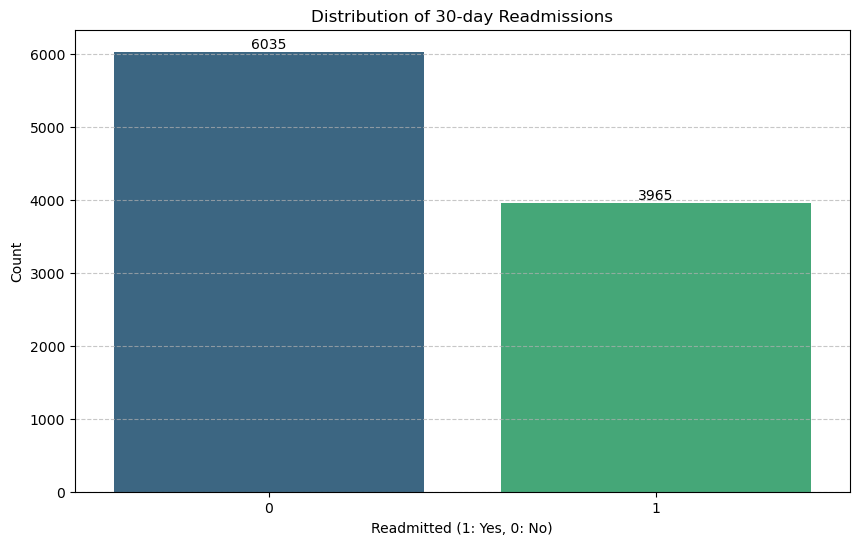

Readmission Rate: 39.65%

Detailed Statistics:
--------------------------------------------------
Total patients: 10000
Number of readmissions: 3965
Number of non-readmissions: 6035


In [140]:
# Create binary readmission target - directly convert boolean to int
df['readmitted_30'] = df['readmitted'].astype(int)

# Verify the values
print("Value counts in readmitted_30:")
print(df['readmitted_30'].value_counts())

# Plot readmission distribution with adjusted figure size and style
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='readmitted_30', palette='viridis')
plt.title('Distribution of 30-day Readmissions')
plt.xlabel('Readmitted (1: Yes, 0: No)')
plt.ylabel('Count')

# Add value labels on top of each bar
for i in plt.gca().containers:
    plt.gca().bar_label(i)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Print readmission rate
readmission_rate = df['readmitted_30'].mean() * 100
print(f"Readmission Rate: {readmission_rate:.2f}%")

# Additional statistics
print("\nDetailed Statistics:")
print("-" * 50)
print("Total patients:", len(df))
print("Number of readmissions:", df['readmitted_30'].sum())
print("Number of non-readmissions:", len(df) - df['readmitted_30'].sum())


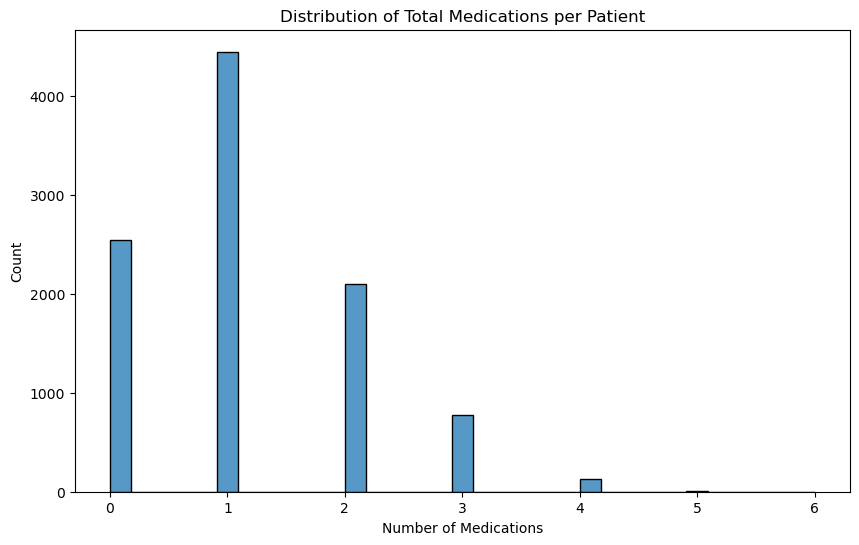

In [141]:
# Create binary readmission target - directly convert boolean to int
df['readmitted_30'] = df['readmitted'].astype(int)

# Verify the values
print("Value counts in readmitted_30:")
print(df['readmitted_30'].value_counts())

# Plot readmission distribution with adjusted figure size and style
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='readmitted_30', palette='viridis')
plt.title('Distribution of 30-day Readmissions')
plt.xlabel('Readmitted (1: Yes, 0: No)')
plt.ylabel('Count')

# Add value labels on top of each bar
for i in plt.gca().containers:
    plt.gca().bar_label(i)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Print readmission rate
readmission_rate = df['readmitted_30'].mean() * 100
print(f"Readmission Rate: {readmission_rate:.2f}%")

# Additional statistics
print("\nDetailed Statistics:")
print("-" * 50)
print("Total patients:", len(df))
print("Number of readmissions:", df['readmitted_30'].sum())
print("Number of non-readmissions:", len(df) - df['readmitted_30'].sum())

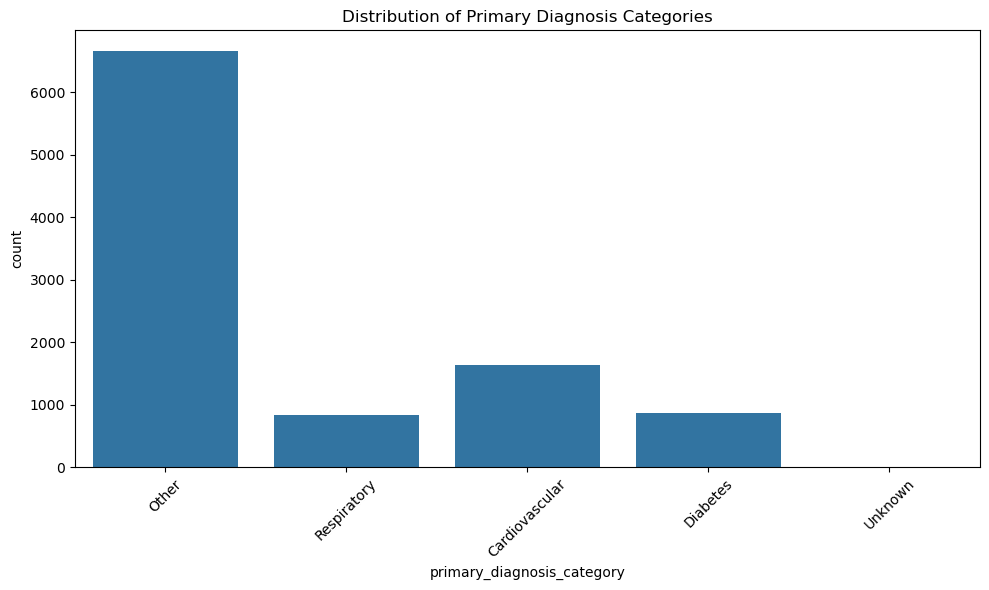

In [142]:
def categorize_diagnosis(diag_desc):
    if pd.isna(diag_desc):
        return 'Unknown'
    diag_lower = str(diag_desc).lower()
    if 'diabetes' in diag_lower:
        return 'Diabetes'
    elif any(x in diag_lower for x in ['heart', 'cardiac', 'coronary']):
        return 'Cardiovascular'
    elif any(x in diag_lower for x in ['respiratory', 'pneumonia', 'copd']):
        return 'Respiratory'
    else:
        return 'Other'

# Categorize primary diagnosis
df['primary_diagnosis_category'] = df['diag_1_desc'].apply(categorize_diagnosis)

# Create dummy variables for diagnosis categories
diagnosis_dummies = pd.get_dummies(df['primary_diagnosis_category'], 
                                 prefix='diag_cat')
df = pd.concat([df, diagnosis_dummies], axis=1)

# Visualize diagnosis distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='primary_diagnosis_category')
plt.xticks(rotation=45)
plt.title('Distribution of Primary Diagnosis Categories')
plt.tight_layout()
plt.show()

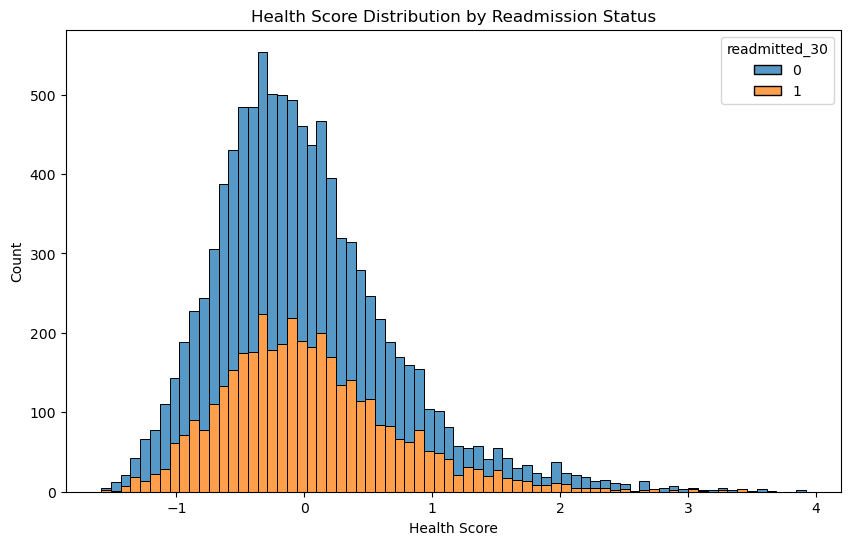

In [143]:
# Normalize components
numerical_cols = ['num_lab_procedures', 'num_procedures', 'num_medications']
scaler = StandardScaler()
normalized_vals = scaler.fit_transform(df[numerical_cols])

# Create health score
df['health_score'] = (normalized_vals[:, 0] * 0.3 + 
                     normalized_vals[:, 1] * 0.3 + 
                     normalized_vals[:, 2] * 0.4)

# Visualize health score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='health_score', hue='readmitted_30', multiple="stack")
plt.title('Health Score Distribution by Readmission Status')
plt.xlabel('Health Score')
plt.ylabel('Count')
plt.show()

In [144]:
# One-hot encoding for nominal categorical variables
nominal_features = ['race', 'gender', 'medical_specialty']
for feature in nominal_features:
    dummies = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(feature, axis=1)

# Label encoding for ordinal variables
ordinal_features = ['discharge_disposition_id', 'admission_source_id']
le = LabelEncoder()
for feature in ordinal_features:
    df[f'{feature}_encoded'] = le.fit_transform(df[feature].astype(str))

In [145]:
# Interaction features
df['procedure_medication_interaction'] = df['num_procedures'] * df['total_medications']
df['lab_medication_interaction'] = df['num_lab_procedures'] * df['total_medications']

 # Medical complexity score incorporating diagnosis category
df['medical_complexity'] = (
    df['num_lab_procedures'] * 0.4 +
    df['num_procedures'] * 0.3 +
    df['total_medications'] * 0.3 +
    (df['diag_cat_Diabetes'].fillna(0) * 0.2) +  # Extra weight for diabetes diagnosis
    (df['diag_cat_Cardiovascular'].fillna(0) * 0.2)  # Extra weight for cardiovascular diagnosis
)

# Diagnosis severity indicator
df['diagnosis_severity'] = (
    (df['diag_cat_Diabetes'].fillna(0) * 3) +
    (df['diag_cat_Cardiovascular'].fillna(0) * 2) +
    (df['diag_cat_Respiratory'].fillna(0) * 2) +
    (df['diag_cat_Other'].fillna(0) * 1)
)

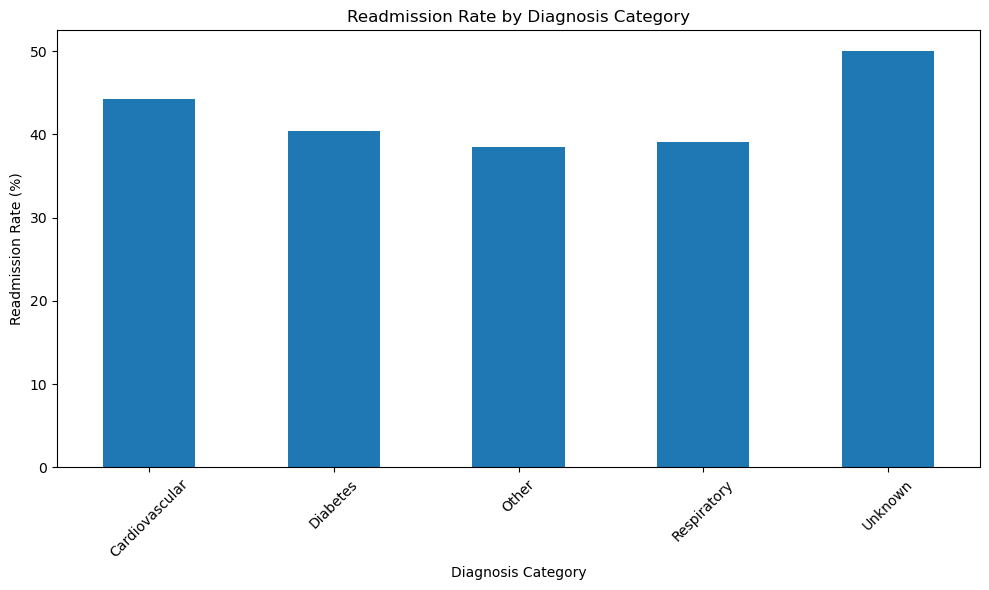

In [146]:
# Show relationship between diagnosis category and readmission
plt.figure(figsize=(10, 6))
readmission_by_diagnosis = df.groupby('primary_diagnosis_category')['readmitted_30'].mean() * 100
readmission_by_diagnosis.plot(kind='bar')
plt.title('Readmission Rate by Diagnosis Category')
plt.xlabel('Diagnosis Category')
plt.ylabel('Readmission Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Modelling


In [147]:
def prepare_modeling_features(df):
    """Prepare final feature set for modeling"""
    # Select relevant features
    feature_cols = [
        # Original numerical features
        'age_numeric', 'time_in_hospital', 'num_lab_procedures',
        'num_procedures', 'total_medications', 'health_score',
        'medical_complexity', 'procedure_medication_interaction',
        'lab_medication_interaction',
        
        # Encoded ordinal features
        'discharge_disposition_id_encoded', 
        'admission_source_id_encoded',
        
        'insulin_status', 'medication_changes',
        
        # Diagnosis-related features
        'diagnosis_severity',
        'diag_cat_Diabetes', 'diag_cat_Cardiovascular',
        'diag_cat_Respiratory', 'diag_cat_Other'
    ]
    
    # Get all dummy columns from preprocessing
    dummy_cols = [col for col in df.columns if any(x in col for x in 
                 ['race_', 'gender_', 'medical_specialty_'])]
    
    # Combine features
    final_features = feature_cols + dummy_cols
    
    # Verify all columns exist in dataframe
    existing_cols = [col for col in final_features if col in df.columns]
    missing_cols = set(final_features) - set(existing_cols)
    
    if missing_cols:
        print(f"Warning: The following columns are missing: {missing_cols}")
    
    # Print feature composition
    print("\nFeature composition:")
    print(f"Base features: {len(feature_cols)}")
    print(f"Dummy variables: {len(dummy_cols)}")
    print(f"Total features: {len(existing_cols)}")
    
    # Return only the columns that exist
    return df[existing_cols]

# Prepare features for modeling
X = prepare_modeling_features(df)

# Define target variable
y = df['readmitted_30']  # Using the binary readmission target

# Print feature information
print(f"\nTotal number of features: {X.shape[1]}")
print("\nFeature types:")
print(X.dtypes.value_counts())
print("\nFeature categories:")

# Group features by type
base_features = [col for col in X.columns if '_' not in col]
race_features = [col for col in X.columns if 'race_' in col]
gender_features = [col for col in X.columns if 'gender_' in col]
specialty_features = [col for col in X.columns if 'medical_specialty_' in col]
diag_features = [col for col in X.columns if 'diag_cat_' in col]

print("\nBase features:", len(base_features))
print("Race dummy variables:", len(race_features))
print("Gender dummy variables:", len(gender_features))
print("Medical specialty dummy variables:", len(specialty_features))
print("Diagnosis category features:", len(diag_features))

# Print target variable distribution
print("\nTarget variable distribution:")
print(y.value_counts(normalize=True))

# First check the data before split
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("\nValue counts in y:")
print(y.value_counts())

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=123,
    stratify=y
)

# Print split information
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"\nClass distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in testing set:\n{y_test.value_counts(normalize=True)}")



Feature composition:
Base features: 18
Dummy variables: 61
Total features: 79

Total number of features: 79

Feature types:
bool       65
int64      11
float64     3
Name: count, dtype: int64

Feature categories:

Base features: 0
Race dummy variables: 6
Gender dummy variables: 2
Medical specialty dummy variables: 53
Diagnosis category features: 4

Target variable distribution:
readmitted_30
0    0.6035
1    0.3965
Name: proportion, dtype: float64
Shape of X: (10000, 79)
Shape of y: (10000,)

Value counts in y:
readmitted_30
0    6035
1    3965
Name: count, dtype: int64

Training set shape: (8000, 79)
Testing set shape: (2000, 79)

Class distribution in training set:
readmitted_30
0    0.6035
1    0.3965
Name: proportion, dtype: float64
Class distribution in testing set:
readmitted_30
0    0.6035
1    0.3965
Name: proportion, dtype: float64


In [148]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.svm import SVR
# from lightgbm import LGBMRegressor

# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from lightgbm import LGBMClassifier

In [149]:





def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate both Random Forest and XGBoost models
    """
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=123,
            class_weight='balanced'
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=123,
            scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])  # Handle class imbalance
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'auc_roc': roc_auc_score(y_test, y_pred_proba),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'feature_importance': model.feature_importances_,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        results[name]['cv_scores'] = cv_scores
        
        # Print results
        print(f"\n{name} Results:")
        print("-" * 50)
        print(f"Accuracy: {results[name]['accuracy']:.4f}")
        print(f"Precision: {results[name]['precision']:.4f}")
        print(f"Recall: {results[name]['recall']:.4f}")
        print(f"F1 Score: {results[name]['f1']:.4f}")
        print(f"ROC-AUC Score: {results[name]['auc_roc']:.4f}")
        print(f"\nCross-validation ROC-AUC Scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return results, models

In [150]:
def plot_model_results(results, X_train, models):
    """
    Create visualizations for model results
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(15, 10))
    
    # 1. ROC Curves
    plt.subplot(2, 2, 1)
    for name in results.keys():
        fpr, tpr, _ = roc_curve(y_test, results[name]['probabilities'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["auc_roc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    
    # 2. Confusion Matrices
    plt.subplot(2, 2, 2)
    cm_rf = results['Random Forest']['confusion_matrix']
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.subplot(2, 2, 3)
    cm_xgb = results['XGBoost']['confusion_matrix']
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 3. Feature Importance
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance_rf': results['Random Forest']['feature_importance'],
        'importance_xgb': results['XGBoost']['feature_importance']
    })
    
    # Sort by average importance
    feature_importance['avg_importance'] = (feature_importance['importance_rf'] + 
                                          feature_importance['importance_xgb']) / 2
    feature_importance = feature_importance.sort_values('avg_importance', ascending=False).head(15)
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='importance_rf', y='feature', data=feature_importance)
    plt.title('Random Forest Feature Importance')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='importance_xgb', y='feature', data=feature_importance)
    plt.title('XGBoost Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

In [151]:
# Train and evaluate models
results, models = train_and_evaluate_models(X_train, X_test, y_train, y_test)



Training Random Forest...

Random Forest Results:
--------------------------------------------------
Accuracy: 0.6095
Precision: 0.5069
Recall: 0.5586
F1 Score: 0.5315
ROC-AUC Score: 0.6443

Cross-validation ROC-AUC Scores: 0.6499 (+/- 0.0223)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.64      0.67      1207
           1       0.51      0.56      0.53       793

    accuracy                           0.61      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.62      0.61      0.61      2000


Training XGBoost...

XGBoost Results:
--------------------------------------------------
Accuracy: 0.5995
Precision: 0.4955
Recall: 0.5612
F1 Score: 0.5263
ROC-AUC Score: 0.6300

Cross-validation ROC-AUC Scores: 0.6364 (+/- 0.0208)

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1207
           1       0.50      0.56     

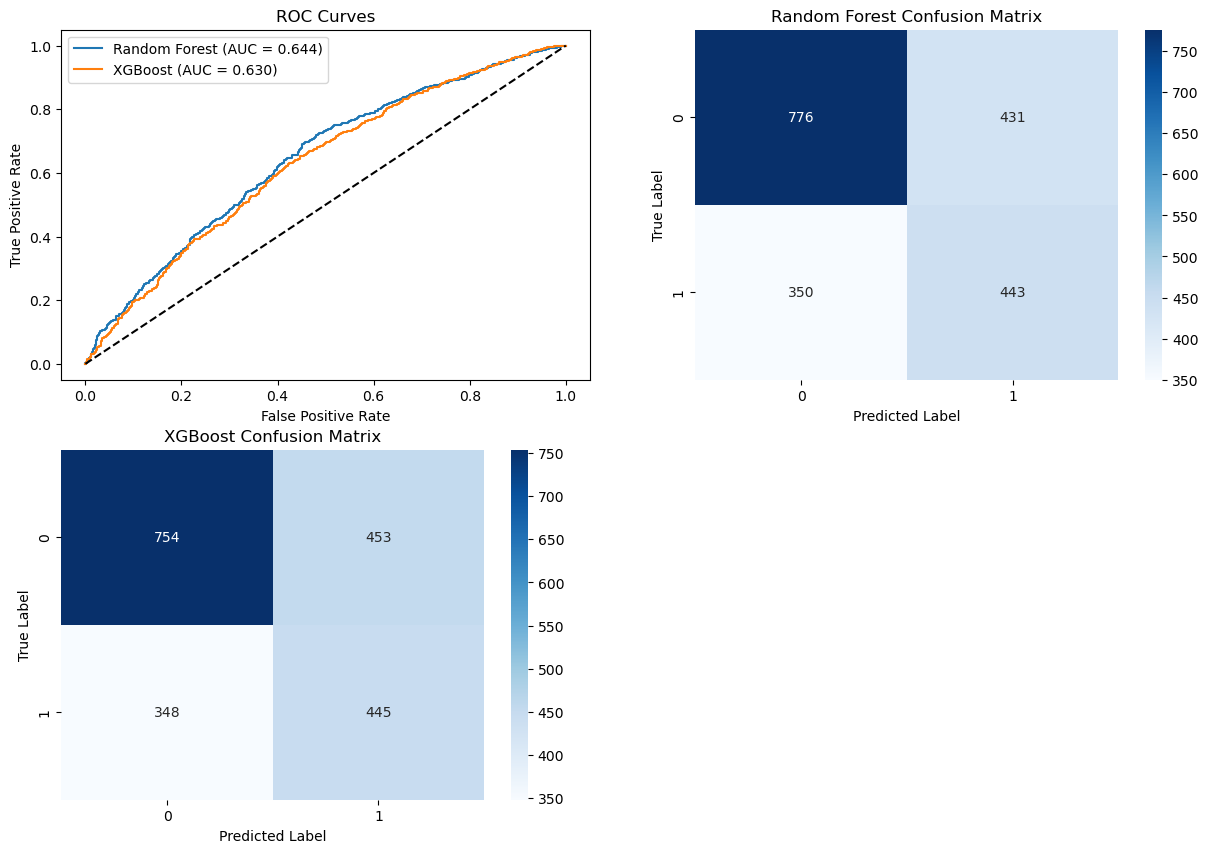

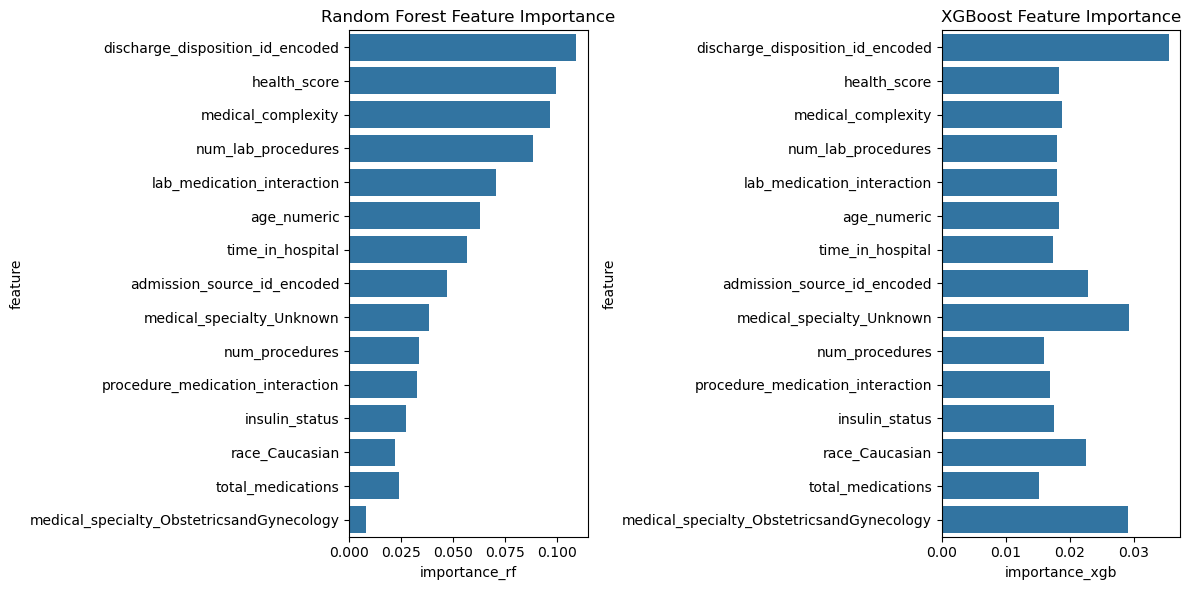

In [152]:
# Plot results
feature_importance = plot_model_results(results, X_train, models)

In [153]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.svm import SVR
# from lightgbm import LGBMRegressor

# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from lightgbm import LGBMClassifier

In [154]:
# For Resource Optimization
resource_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'SVR': SVR(kernel='rbf'),
    'LightGBM': LGBMRegressor(random_state=42)
}


readmission_models = {
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'LightGBM': LGBMClassifier(random_state=42)
}

In [155]:
def prep_resource_features(df):
    """
    Prepare features for resource optimization model, including additional features.
    """
    # Original resource optimization features
    base_resource_features = [
        'time_in_hospital',
        'num_lab_procedures',
        'num_procedures',
        'total_medications',
        'number_emergency',
        'number_inpatient',
        'age_numeric',
        'discharge_disposition_id_encoded',
        'admission_source_id_encoded'
    ] + [col for col in df.columns if col.startswith(('diag_cat_'))]
    
    # Additional features from the second code
    additional_features = [
        'health_score', 'medical_complexity',
        'procedure_medication_interaction', 'lab_medication_interaction',
        'diagnosis_severity', 'insulin_status', 'medication_changes'
    ]
    
    # Dummy columns for categorical features
    dummy_cols = [col for col in df.columns if any(x in col for x in ['race_', 'gender_', 'medical_specialty_'])]
    
    # Combine all features
    resource_features = base_resource_features + additional_features + dummy_cols
    
    # Check for missing columns in the DataFrame
    existing_cols = [col for col in resource_features if col in df.columns]
    missing_cols = set(resource_features) - set(existing_cols)
    
    if missing_cols:
        print(f"Warning: The following columns are missing and will be excluded: {missing_cols}")
    
    return existing_cols



In [156]:
# Prepare resource features and target variables
resource_features = prep_resource_features(df)
X_resource = df[resource_features]
y_los = df['time_in_hospital']
y_procedures = df['num_procedures']
y_medications = df['total_medications']

# Prepare readmission features and target variable
X_readmission = prepare_modeling_features(df)
y_readmission = df['readmitted_30']

# Split the data for Resource Optimization
X_resource_train, X_resource_test, y_los_train, y_los_test = train_test_split(
    X_resource, y_los, test_size=0.2, random_state=42
)

# Split the data for Readmission Prevention
X_readm_train, X_readm_test, y_readm_train, y_readm_test = train_test_split(
    X_readmission, y_readmission, test_size=0.2, random_state=42
)



Feature composition:
Base features: 18
Dummy variables: 61
Total features: 79


In [157]:
def compare_models(models, X_train, X_test, y_train, y_test, task='classification'):
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        if task == 'classification':
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
            results[name] = {
                'Accuracy': accuracy,
                'AUC-ROC': auc
            }
        else:  # regression
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            results[name] = {
                'MSE': mse,
                'R2': r2
            }
    
    return pd.DataFrame(results).T

# Compare Resource Optimization Models
resource_results = compare_models(
    resource_models, 
    X_resource_train, 
    X_resource_test, 
    y_los_train, 
    y_los_test, 
    task='regression'
)

# Compare Readmission Prevention Models
readmission_results = compare_models(
    readmission_models, 
    X_readm_train, 
    X_readm_test, 
    y_readm_train, 
    y_readm_test, 
    task='classification'
)

print("\nResource Optimization Model Comparison:")
print(resource_results)
print("\nReadmission Prevention Model Comparison:")
print(readmission_results)


Training Random Forest...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training SVR...

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 51
[LightGBM] [Info] Start training from score 4.441125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [161]:
# Resource Optimization (Regression Models) - Parameter grids for GridSearchCV
param_grid_resource = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20]
    },
    'Linear Regression': {},
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'Lasso': {
        'alpha': [0.1, 1.0, 10.0]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'LightGBM': {
        'num_leaves': [31, 50],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [50, 100]
    }
}

# Readmission Prevention (Classification Models) - Parameter grids for GridSearchCV
param_grid_readmission = {
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Naive Bayes': {},
    'LightGBM': {
        'num_leaves': [31, 50],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [50, 100]
    }
}

# Models for Resource Optimization
resource_models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'SVR': SVR(),
    'LightGBM': LGBMRegressor(random_state=42)
}

# Models for Readmission Prevention
readmission_models = {
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'Naive Bayes': GaussianNB(),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Placeholder to store results
cross_val_results = {}

# Perform cross-validation and hyperparameter tuning for Resource Optimization models
for name, model in resource_models.items():
    if name in param_grid_resource:  # Skip models with empty grids
        print(f"Tuning {name} for Resource Optimization...")
        
        # Apply GridSearchCV for tuning
        grid = GridSearchCV(
            model, 
            param_grid_resource[name], 
            cv=5, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1,
            verbose=1  # Optional: set to 1 or 2 for progress updates
        )
        
        grid.fit(X_resource_train, y_los_train)  # `time_in_hospital` as the target variable for demonstration
        
        # Cross-validation score and best parameters
        best_score = grid.best_score_
        best_params = grid.best_params_
        cross_val_results[f'Resource Model: {name}'] = {
            'Best Score': best_score, 
            'Best Params': best_params,
            'Best Estimator': grid.best_estimator_
        }
        
        print(f"Best Score for {name}: {best_score}")
        print(f"Best Parameters for {name}: {best_params}")
        print("-" * 40)

# Perform cross-validation and hyperparameter tuning for Readmission Prevention models
for name, model in readmission_models.items():
    if name in param_grid_readmission:  # Skip models with empty grids
        print(f"Tuning {name} for Readmission Prevention...")
        
        # Apply GridSearchCV for tuning
        grid = GridSearchCV(
            model, 
            param_grid_readmission[name], 
            cv=5, 
            scoring='roc_auc',  # Using ROC AUC for classification models
            n_jobs=-1,
            verbose=1  # Optional: set to 1 or 2 for progress updates
        )
        
        grid.fit(X_readm_train, y_readm_train)
        
        # Cross-validation score and best parameters
        best_score = grid.best_score_
        best_params = grid.best_params_
        cross_val_results[f'Readmission Model: {name}'] = {
            'Best Score': best_score, 
            'Best Params': best_params,
            'Best Estimator': grid.best_estimator_
        }
        
        print(f"Best Score for {name}: {best_score}")
        print(f"Best Parameters for {name}: {best_params}")
        print("-" * 40)

# Display cross-validation results summary
cross_val_results

Tuning Random Forest for Resource Optimization...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score for Random Forest: 0.0
Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}
----------------------------------------
Tuning Linear Regression for Resource Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Score for Linear Regression: -1.7691774193944736e-14
Best Parameters for Linear Regression: {}
----------------------------------------
Tuning Ridge for Resource Optimization...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score for Ridge: -4.2273142517963475e-11
Best Parameters for Ridge: {'alpha': 0.1}
----------------------------------------
Tuning Lasso for Resource Optimization...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score for Lasso: -0.0011348690316334924
Best Parameters for Lasso: {'alpha': 0.1}
----------------------------------------
Tuning SVR for Resource O

{'Resource Model: Random Forest': {'Best Score': 0.0,
  'Best Params': {'max_depth': None, 'n_estimators': 50},
  'Best Estimator': RandomForestRegressor(n_estimators=50, random_state=42)},
 'Resource Model: Linear Regression': {'Best Score': -1.7691774193944736e-14,
  'Best Params': {},
  'Best Estimator': LinearRegression()},
 'Resource Model: Ridge': {'Best Score': -4.2273142517963475e-11,
  'Best Params': {'alpha': 0.1},
  'Best Estimator': Ridge(alpha=0.1, random_state=42)},
 'Resource Model: Lasso': {'Best Score': -0.0011348690316334924,
  'Best Params': {'alpha': 0.1},
  'Best Estimator': Lasso(alpha=0.1, random_state=42)},
 'Resource Model: SVR': {'Best Score': -0.004325766510843642,
  'Best Params': {'C': 0.1, 'kernel': 'linear'},
  'Best Estimator': SVR(C=0.1, kernel='linear')},
 'Resource Model: LightGBM': {'Best Score': -6.410522669087528e-09,
  'Best Params': {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31},
  'Best Estimator': LGBMRegressor(random_state=42)},

In [158]:
# Save best model 
best_model = models['XGBoost']

# Function for making predictions on new data
def predict_readmission(model, new_data):
    """
    Make predictions on new data using the trained model
    """
    probabilities = model.predict_proba(new_data)[:, 1]
    predictions = model.predict(new_data)
    return predictions, probabilities